In [1]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

# Modelo KNN de Regression con cross validation (Separando las dos ciudades)

In [2]:
# Importamos los dos ficheros el train y el test
url1 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_features_test.csv'
dftest = pd.read_csv(url1)
url2 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_features_train.csv'
dftrain = pd.read_csv(url2)
url3 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/dengue_labels_train.csv'
dftrainlabel = pd.read_csv(url3)

### Ajuste de las Variables

In [3]:
dftrain['total_cases'] = dftrainlabel["total_cases"]

In [4]:
#Rellenamos los valores que se encuentran nulos
dftrain = dftrain.fillna(dftrain.rolling(20, min_periods=1).mean())
dftest = dftest.fillna(dftest.rolling(20, min_periods=1).mean())

A continuación, lo que vamos a hacer es quitar o sustituir los valores que yo considere oportunos para poder empezar con el estudio de los datos.

In [5]:
dftrain.drop(['reanalysis_max_air_temp_k'], axis = 1, inplace=True)
dftrain.drop(['reanalysis_min_air_temp_k'], axis = 1, inplace=True)

dftest.drop(['reanalysis_max_air_temp_k'], axis = 1, inplace=True)
dftest.drop(['reanalysis_min_air_temp_k'], axis = 1, inplace=True)

In [6]:

dftrain.drop(['station_max_temp_c'], axis = 1, inplace=True)
dftrain.drop(['station_min_temp_c'], axis = 1, inplace=True)

dftest.drop(['station_max_temp_c'], axis = 1, inplace=True)
dftest.drop(['station_min_temp_c'], axis = 1, inplace=True)

In [7]:
dftrain.drop(['week_start_date'], axis = 1, inplace=True)
dftest.drop(['week_start_date'], axis = 1, inplace=True)

Y antes de hacer la Matriz de correlación lo que vamos a hacer es pasar todos los datos categóricos a numéricos.

In [8]:
dftrain.city.value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [9]:
dftrain['city'] = dftrain['city'].replace({'sj': 0, 'iq': 1})
dftest['city'] = dftest['city'].replace({'sj': 0, 'iq': 1})

dftrain = dftrain.loc[(dftrain['year'] >= 2008)  &  (dftrain['year'] <= 2010)]

In [10]:
dftrain_sj = dftrain.loc[dftrain['city'] == 0]
dftrain_iq = dftrain.loc[dftrain['city'] == 1]

dftest_sj = dftest.loc[dftest['city'] == 0]
dftest_iq = dftest.loc[dftest['city'] == 1]

**Matríz de Correlación**

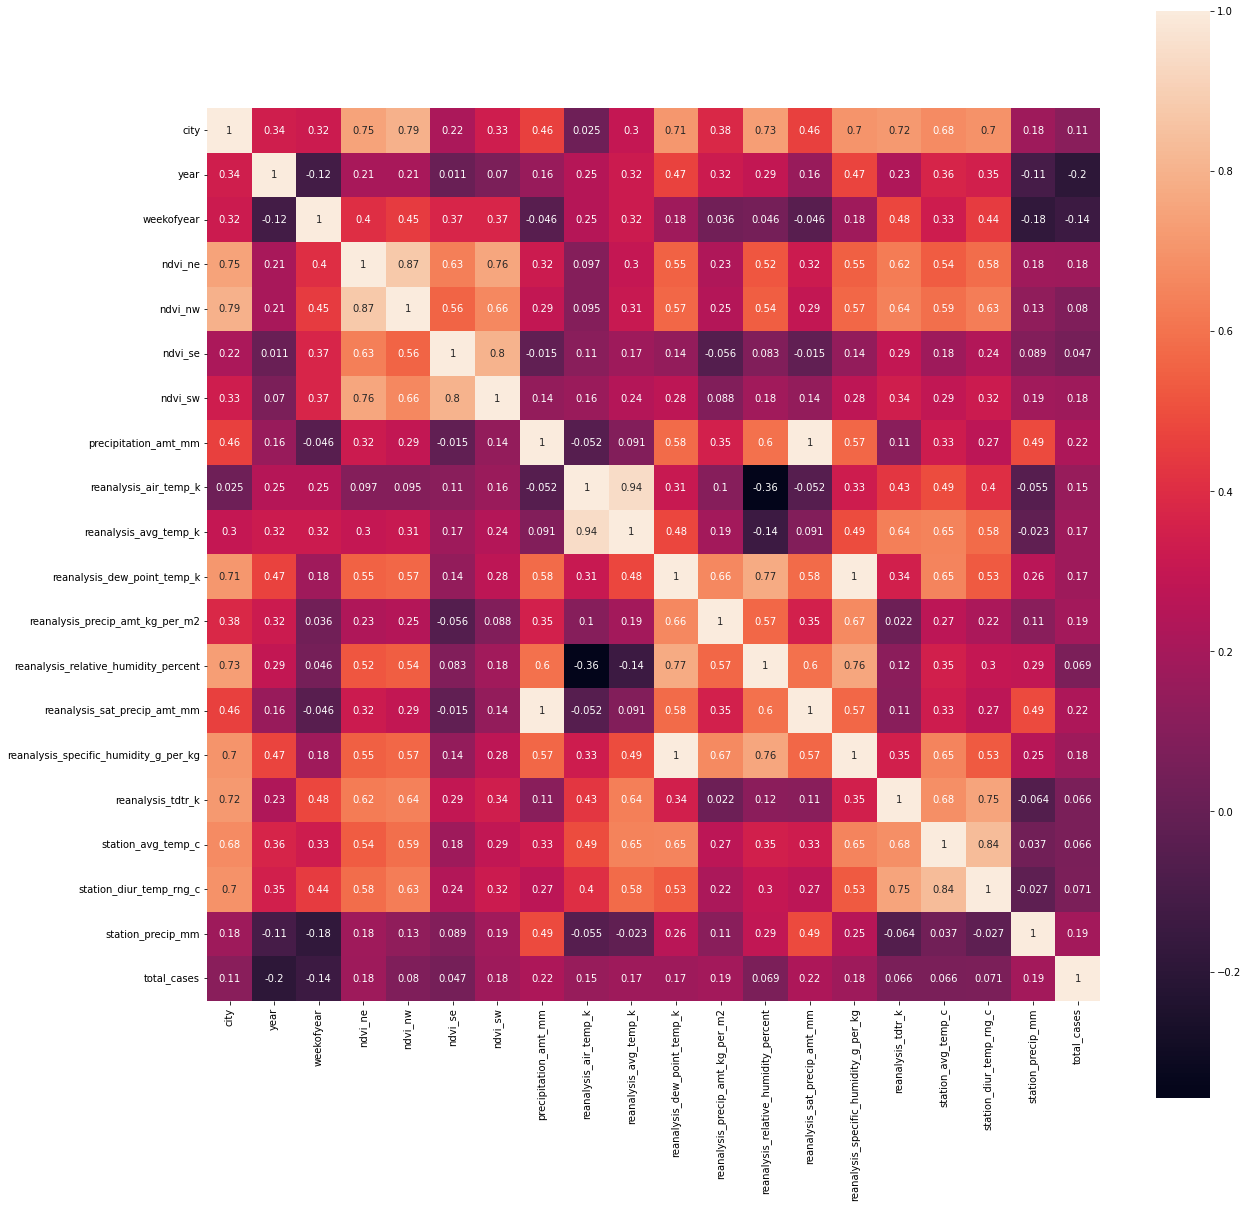

In [11]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(dftrain.corr(), annot=True, square=True)
plt.show()

In [12]:
from numpy.core import numeric
from sklearn.model_selection import train_test_split

# separamos datos de entrada y salida
X_sj = dftrain_sj.drop('total_cases', axis=1)
y_sj = dftrain_sj['total_cases']

# separamos train y test
x_train_sj, x_test_sj, y_train_sj, y_test_sj = train_test_split(X_sj, y_sj, test_size=0.30, random_state=5)

Min Value uniform : 4.066666666666667 (5)
Min Value distance : 4.121319483129071 (5)


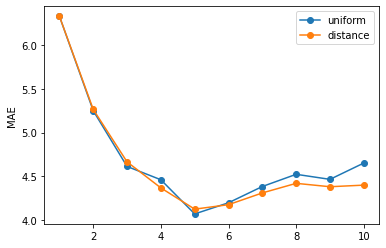

In [13]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = TimeSeriesSplit(n_splits = 5)
x_train_sj.reset_index(drop = True, inplace = True) # reinicia índice

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,11):
       fold_accuracy = []
       knn = KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(x_train_sj):
          # División train test aleatoria
          f_train_sj = x_train_sj.loc[train_fold]
          f_test_sj = x_train_sj.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit(x_train_sj,y_train_sj)
          y_pred = knn.predict(x_test_sj)
          # evaluación del modelo
          mae = mean_absolute_error(y_test_sj, y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')     

plt.legend()
plt.show()

Text(0, 0.5, 'Predicted total_cases')

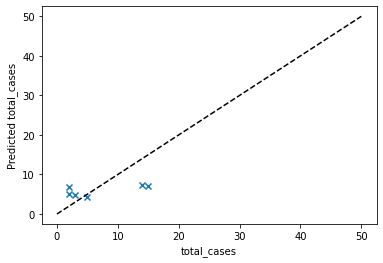

In [14]:
import matplotlib.pyplot as plt

knn = KNeighborsRegressor(n_neighbors= (np.argmin(total_scores) + 1) , weights= weights)
knn.fit(x_train_sj,y_train_sj)

y_pred_sj = knn.predict(x_test_sj)

plt.scatter(y_test_sj, y_pred_sj, marker = 'x')
plt.plot([0, 50], [0, 50], "--k")
plt.axis("tight")
plt.xlabel("total_cases")
plt.ylabel("Predicted total_cases")

# Interpretación de la gráfica:
# En la diagonal están los valores de test, y los puntos dispersos son las predicción. De esta forma podemos ver lo cerca/lejos que están los resultados
# predichos de los de entrenamiento
# Cuanto más cerca están las X de la recta mejor será la predicción.

In [15]:
from numpy.core import numeric
from sklearn.model_selection import train_test_split

# separamos datos de entrada y salida
X_iq = dftrain_iq.drop('total_cases', axis=1)
y_iq = dftrain_iq['total_cases']

# separamos train y test
x_train_iq, x_test_iq, y_train_iq, y_test_iq = train_test_split(X_iq, y_iq, test_size=0.30, random_state=5)

Min Value uniform : 6.854700854700854 (6)
Min Value distance : 6.769420855889663 (6)


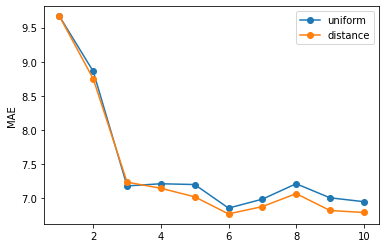

In [16]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = TimeSeriesSplit(n_splits = 5)
x_train_iq.reset_index(drop = True, inplace = True) # reinicia índice

for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,11):
       fold_accuracy = []
       knn = KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(x_train_iq):
          # División train test aleatoria
          f_train_iq = x_train_iq.loc[train_fold]
          f_test_iq = x_train_iq.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit(x_train_iq, y_train_iq)
          y_pred = knn.predict(x_test_iq)
          # evaluación del modelo
          mae = mean_absolute_error(y_test_iq, y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')     

plt.legend()
plt.show()

Text(0, 0.5, 'Predicted total_cases')

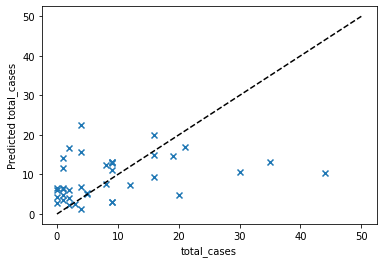

In [17]:
import matplotlib.pyplot as plt

knn = KNeighborsRegressor(n_neighbors= (np.argmin(total_scores) + 1) , weights= weights)
knn.fit(x_train_iq,y_train_iq)

y_pred_iq = knn.predict(x_test_iq)

plt.scatter(y_test_iq, y_pred_iq, marker = 'x')
plt.plot([0, 50], [0, 50], "--k")
plt.axis("tight")
plt.xlabel("total_cases")
plt.ylabel("Predicted total_cases")

# Interpretación de la gráfica:
# En la diagonal están los valores de test, y los puntos dispersos son las predicción. De esta forma podemos ver lo cerca/lejos que están los resultados
# predichos de los de entrenamiento
# Cuanto más cerca están las X de la recta mejor será la predicción.

## Descargar el modelo predicho separado

In [18]:
y_pred_sj = knn.predict(dftest_sj)
y_pred_sj = y_pred_sj.astype(int)
dftest_sj['total_cases'] = y_pred_sj

y_pred_iq = knn.predict(dftest_iq)
y_pred_iq = y_pred_iq.astype(int)
dftest_iq['total_cases'] = y_pred_iq

<ipython-input-18-75148e27725b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_sj['total_cases'] = y_pred_sj
<ipython-input-18-75148e27725b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest_iq['total_cases'] = y_pred_iq


In [19]:
dftest_sj

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_precip_mm,total_cases
0,0,2008,18,-0.01890,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,75.2,15
1,0,2008,19,-0.01800,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,34.3,5
2,0,2008,20,-0.00150,-0.015650,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,3.0,5
3,0,2008,21,-0.01280,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,0.3,5
4,0,2008,22,0.05680,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,84.1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,2013,13,-0.08740,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,3.5,11
256,0,2013,14,-0.20325,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,17.6,6
257,0,2013,15,-0.11760,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,9.4,5
258,0,2013,16,0.08275,0.031200,0.135014,0.074857,0.00,298.912857,299.064286,294.678571,1.40,77.674286,0.00,15.965714,3.042857,27.728571,6.942857,22.9,5


In [20]:
url4 = 'https://raw.githubusercontent.com/Ruben11040/Proyectos_Colab/main/DengAI%3A%20Predicting%20Disease%20Spread/submission_format.csv'
dfsubmission = pd.read_csv(url4)
dfsubmission.drop(['total_cases'], axis = 1, inplace=True)

merged_df_sj = pd.merge(dfsubmission, dftest_sj, on=["year", "weekofyear"], how="outer")
merged_df_iq = pd.merge(dfsubmission, dftest_iq, on=["year", "weekofyear"], how="outer")

merged_df_iq = merged_df_iq.dropna()
merged_df_sj = merged_df_sj.dropna()
#df3 = merged_df.drop(['casos'], axis=1)
#merged_df
#dfsubmission['total_cases'] = y_pred

In [21]:
merged_df = pd.concat([merged_df_sj, merged_df_iq])
merged_df.drop(['city_y'], axis = 1, inplace=True)
merged_df['total_cases'] = merged_df['total_cases'].astype(int)
merged_df

,city_x,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_precip_mm,total_cases
0,sj,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,75.2,15
1,sj,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,34.3,5
2,sj,2008,20,-0.001500,-0.015650,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,3.0,5
3,sj,2008,21,-0.012800,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,0.3,5
4,sj,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,84.1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,33.0,2
412,iq,2013,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,68.0,9
413,iq,2013,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,93.2,21
414,iq,2013,25,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,297.400000,293.648571,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,34.1,4


In [22]:
results = pd.merge(dfsubmission, merged_df, on=["year", "weekofyear"], how="outer")
dfsubmission['total_cases'] = results['total_cases']
dfsubmission

,city,year,weekofyear,total_cases
0,sj,2008,18,15
1,sj,2008,19,5
2,sj,2008,20,5
3,sj,2008,21,5
4,sj,2008,22,13
...,...,...,...,...
411,iq,2013,22,5
412,iq,2013,23,5
413,iq,2013,24,6
414,iq,2013,25,6


In [23]:
dfsubmission.isnull().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

# Descargar el modelo predicho

In [27]:
#dfsubmission.to_csv('resultado.csv', index=False)